# MIRNet

In [1]:
import os
import cv2
import numpy
import random
from PIL import Image, ImageOps
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# !gdown https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLQi6
!gdown https://drive.google.com/u/0/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB

Downloading...
From: https://drive.google.com/u/0/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB
To: /content/LOLdataset.zip
100% 347M/347M [00:05<00:00, 62.6MB/s]


In [3]:
!unzip LOLdataset.zip

Archive:  LOLdataset.zip
   creating: eval15/
   creating: eval15/high/
  inflating: eval15/high/748.png     
   creating: __MACOSX/
   creating: __MACOSX/eval15/
   creating: __MACOSX/eval15/high/
  inflating: __MACOSX/eval15/high/._748.png  
  inflating: eval15/high/665.png     
  inflating: __MACOSX/eval15/high/._665.png  
  inflating: eval15/high/111.png     
  inflating: __MACOSX/eval15/high/._111.png  
  inflating: eval15/high/493.png     
  inflating: __MACOSX/eval15/high/._493.png  
  inflating: eval15/high/22.png      
  inflating: __MACOSX/eval15/high/._22.png  
  inflating: eval15/high/23.png      
  inflating: __MACOSX/eval15/high/._23.png  
  inflating: eval15/high/669.png     
  inflating: __MACOSX/eval15/high/._669.png  
  inflating: eval15/high/547.png     
  inflating: __MACOSX/eval15/high/._547.png  
  inflating: eval15/high/778.png     
  inflating: __MACOSX/eval15/high/._778.png  
  inflating: eval15/high/55.png      
  inflating: __MACOSX/eval15/high/._55.png  
  i

In [4]:
random.seed(10)
IMAGE_SIZE = 128
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300

def read_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels = 3)
  image.set_shape([None, None, 3])
  image = tf.cast(image, dtype=tf.float32)/255.0
  return image

def random_crop(low_image, enhanced_image):
  low_image_shape = tf.shape(low_image)[:2]
  low_w = tf.random.uniform(shape=(), maxval=low_image_shape[1]-IMAGE_SIZE + 1, dtype=tf.int32)
  low_h = tf.random.uniform(shape=(), maxval=low_image_shape[0]-IMAGE_SIZE + 1, dtype=tf.int32)

  enhanced_w = low_w
  enhanced_h = low_h
  low_image_cropped = low_image[
      low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
  ]
  enhanced_image_cropped = enhanced_image[
      enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
  ]
  return low_image_cropped, enhanced_image_cropped

def load_data(low_light_image_path, enhanced_image_path):
  low_light_image = read_image(low_light_image_path)
  enhanced_image = read_image(enhanced_image_path)
  low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
  return low_light_image, enhanced_image

def get_dataset(low_light_images, enhanced_images):
  dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
  dataset = dataset.map(load_data, num_parallel_calls = tf.data.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder= True)
  return dataset

In [5]:
train_low_light_images = sorted(glob("/content/our485/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("/content/our485/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("/content/our485/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("/content/our485/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("/content/eval15/low/*"))
test_enhanced_images = sorted(glob("/content/eval15/high/*"))

train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)

print("Train Dataset", train_dataset)
print("Test Dataset", val_dataset)

Train Dataset <_BatchDataset element_spec=(TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None))>
Test Dataset <_BatchDataset element_spec=(TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None))>


# MIRNet and
# SKFF (Selective Kernal Feature Fusion)

In [6]:
def selective_kernel_feature_fusion(multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3):
  channels = list(multi_scale_feature_1.shape)[-1]

  combined_feature = layers.Add()([multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3])

  gap = layers.GlobalAveragePooling2D()(combined_feature)

  channel_wise_statistics = tf.reshape(gap, shape =(-1, 1, 1, channels))

  compact_feature_representation = layers.Conv2D(
      filters = channels//8, kernel_size = (1,1), activation = "relu"
  )(channel_wise_statistics)

  feature_descriptor_1 = layers.Conv2D(
      channels, kernel_size=(1,1), activation = "softmax"
  )(compact_feature_representation)

  feature_descriptor_2 = layers.Conv2D(
      channels, kernel_size=(1,1), activation = "softmax"
  )(compact_feature_representation)

  feature_descriptor_3 = layers.Conv2D(
      channels, kernel_size=(1,1), activation = "softmax"
  )(compact_feature_representation)

  feature_1 = multi_scale_feature_1 * feature_descriptor_1
  feature_2 = multi_scale_feature_2 * feature_descriptor_2
  feature_3 = multi_scale_feature_3 * feature_descriptor_3

  aggregated = layers.Add()([feature_1, feature_2, feature_3])
  return aggregated

In [7]:
 def spatial_attention_block(input_tensor):
  average_pooling = tf.reduce_max(input_tensor, axis = -1)
  average_pooling = tf.expand_dims(average_pooling, axis = -1)
  max_pooling = tf.reduce_mean(input_tensor, axis = -1)
  max_pooling = tf.expand_dims(max_pooling, axis = -1)
  concatenated = layers.Concatenate(axis= -1)([average_pooling, max_pooling])
  feature_map = layers.Conv2D(1, kernel_size=(1,1))(concatenated)
  feature_map = tf.nn.sigmoid(feature_map)
  return input_tensor*feature_map

def channel_attention_block(input_tensor):
  channels = list(input_tensor.shape)[-1]
  average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
  feature_descriptor = tf.reshape(average_pooling, shape=(-1, 1, 1, channels)) ## changed (-1, 1, 1, channels)
  feature_activations = layers.Conv2D(
      filters = channels//8, kernel_size = (1,1), activation = "relu"
  )(feature_descriptor)
  feature_activations = layers.Conv2D(
      filters = channels, kernel_size = (1,1), activation = "sigmoid"
  )(feature_activations)
  return input_tensor*feature_activations

def dual_attention_block(input_tensor):
  channels = list(input_tensor.shape)[-1]
  feature_map = layers.Conv2D(
      channels, kernel_size = (3, 3), padding = "same", activation = "relu"
  )(input_tensor)
  feature_map = layers.Conv2D(
      channels, kernel_size = (3, 3), padding = "same"
  )(feature_map)
  channel_attention = channel_attention_block(feature_map)
  spatial_attention = spatial_attention_block(feature_map)
  concatenation = layers.Concatenate(axis = -1)([channel_attention, spatial_attention])
  concatenation = layers.Conv2D(channels, kernel_size=(1,1))(concatenation)
  return layers.Add()([input_tensor, concatenation])

In [8]:
def down_sampling_module(input_tensor):
  channels = list(input_tensor.shape)[-1]
  main_branch = layers.Conv2D(channels, kernel_size=(1,1), activation="relu")(input_tensor)
  main_branch = layers.Conv2D(channels, kernel_size=(3,3),padding = "same", activation="relu")(main_branch)
  main_branch = layers.MaxPooling2D()(main_branch)
  main_branch = layers.Conv2D(channels*2, kernel_size = (1, 1))(main_branch)
  skip_branch = layers.MaxPooling2D()(input_tensor)
  skip_branch = layers.Conv2D(channels*2, kernel_size = (1, 1))(skip_branch)
  return layers.Add()([skip_branch, main_branch])

def up_sampling_module(input_tensor):
  channels = list(input_tensor.shape)[-1]
  main_branch = layers.Conv2D(channels, kernel_size=(1,1), activation= "relu")(input_tensor)
  main_branch = layers.Conv2D(channels, kernel_size=(3,3),padding="same", activation= "relu")(main_branch)
  main_branch = layers.UpSampling2D()(main_branch)
  main_branch = layers.Conv2D(channels//2, kernel_size=(1,1))(main_branch)
  skip_branch = layers.UpSampling2D()(input_tensor)
  skip_branch = layers.Conv2D(channels//2, kernel_size= (1,1))(skip_branch)
  return layers.Add()([skip_branch, main_branch])

def multi_scale_residual_block(input_tensor, channels):
  level1 = input_tensor
  level2 = down_sampling_module(input_tensor)
  level3 = down_sampling_module(level2)

  level1_dau = dual_attention_block(level1)
  level2_dau = dual_attention_block(level2)
  level3_dau = dual_attention_block(level3)

  level1_skff = selective_kernel_feature_fusion(
      level1_dau,
      up_sampling_module(level2_dau),
      up_sampling_module(up_sampling_module(level3_dau)),
  )

  level2_skff = selective_kernel_feature_fusion(
      down_sampling_module(level1_dau),
      level2_dau,
      up_sampling_module(level3_dau)
  )

  level3_skff = selective_kernel_feature_fusion(
      down_sampling_module(down_sampling_module(level1_dau)),
      down_sampling_module(level2_dau),
      level3_dau,
  )
  level1_dau_2 = dual_attention_block(level1_skff)
  level2_dau_2 = up_sampling_module((dual_attention_block(level2_skff)))
  level3_dau_2 = up_sampling_module(up_sampling_module(dual_attention_block(level3_skff)))

  skff_ = selective_kernel_feature_fusion(level1_dau_2, level3_dau_2, level3_dau_2)
  conv = layers.Conv2D(channels, kernel_size=(3,3), padding="same")(skff_)
  return layers.Add()([input_tensor, conv])

# MIRNet Model

In [9]:
def recursive_residual_group(input_tensor, num_mrb, channels):
  conv1 = layers.Conv2D(channels, kernel_size=(3,3), padding="same")(input_tensor)
  for _ in range(num_mrb):
    conv1=multi_scale_residual_block(conv1, channels)
  conv2 = layers.Conv2D(channels, kernel_size = (3, 3), padding = "same")(conv1)
  return layers.Add()([conv2, input_tensor])

def mirnet_model(num_rrg, num_mrb, channels):
  input_tensor = keras.Input(shape=[None, None, 3])
  x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
  for _ in range(num_rrg):
    x1 = recursive_residual_group(x1, num_mrb, channels)
  conv = layers.Conv2D(3, kernel_size=(3,3), padding = "same")(x1)
  output_tensor = layers.Add()([input_tensor, conv])
  return keras.Model(input_tensor, output_tensor)

model = mirnet_model(num_rrg=3, num_mrb=2, channels = 64)

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint, EarlyStopping, Callback

def charbonnier_loss(y_true, y_pred):
  return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

def peak_signal_noise_ratio(y_true, y_pred):
  return tf.image.psnr(y_pred, y_true, max_val = 255.0)

optimizer = keras.optimizers.Adam(learning_rate= 1e-4)
model.compile(
    optimizer = optimizer, loss = charbonnier_loss, metrics = [peak_signal_noise_ratio]
)

history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 50,
    callbacks = [
          keras.callbacks.ReduceLROnPlateau(
              monitor = "val_peak_signal_noise_ratio",
              factor = 0.5,
              patience = 5,
              verbose = 1,
              min_delta = 1e-7,
              mode = "max",
          )
    ],
)

Epoch 1/50
75/75 [==============================] - 272s 1s/step - loss: 0.1955 - peak_signal_noise_ratio: 62.3055 - val_loss: 0.1298 - val_peak_signal_noise_ratio: 65.3877 - lr: 1.0000e-04
Epoch 2/50
75/75 [==============================] - 80s 1s/step - loss: 0.1741 - peak_signal_noise_ratio: 63.2494 - val_loss: 0.1231 - val_peak_signal_noise_ratio: 65.6265 - lr: 1.0000e-04
Epoch 3/50
75/75 [==============================] - 80s 1s/step - loss: 0.1708 - peak_signal_noise_ratio: 63.4473 - val_loss: 0.1233 - val_peak_signal_noise_ratio: 65.8531 - lr: 1.0000e-04
Epoch 4/50
75/75 [==============================] - 88s 1s/step - loss: 0.1711 - peak_signal_noise_ratio: 63.4654 - val_loss: 0.1241 - val_peak_signal_noise_ratio: 65.9663 - lr: 1.0000e-04
Epoch 5/50
75/75 [==============================] - 88s 1s/step - loss: 0.1658 - peak_signal_noise_ratio: 63.5963 - val_loss: 0.1177 - val_peak_signal_noise_ratio: 66.0860 - lr: 1.0000e-04
Epoch 6/50
75/75 [==============================] - 88

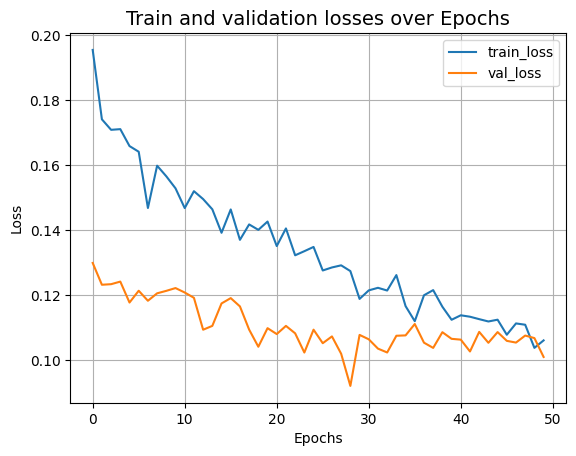

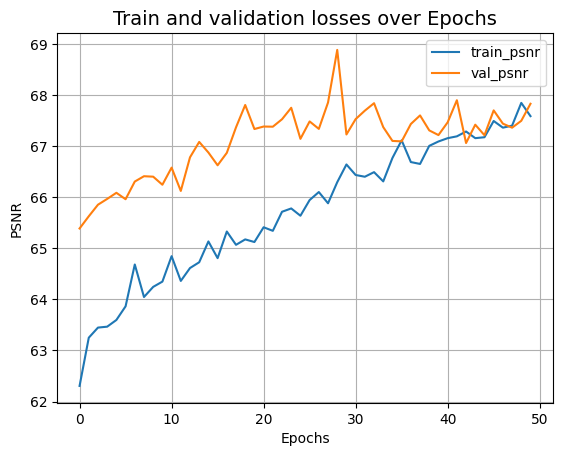

In [11]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and validation losses over Epochs", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history["peak_signal_noise_ratio"], label="train_psnr")
plt.plot(history.history["val_peak_signal_noise_ratio"], label="val_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and validation losses over Epochs", fontsize = 14)
plt.legend()
plt.grid()
plt.show()


# Inferances

In [18]:
import numpy as np
def plot_results(images, titles, figure_size=(12,12)):
    fig = plt.figure(figsize= figure_size)
    for i in range(len(images)):
      fig.add_subplot(1, len(images), i+1).set_title(titles[i])
      _ = plt.imshow(images[i])
      plt.axis("off")
    plt.show()

def infer(original_image):
  image = keras.preprocessing.image.img_to_array(original_image)
  image = image.astype("float32")/255.0
  image = np.expand_dims(image, axis=0)
  output = model.predict(image)
  output_image = output[0]*255.0
  output_image = output_image.clip(0, 255)
  output_image = output_image.reshape(
      (np.shape(output_image)[0], np.shape(output_image)[1], 3)
  )
  output_image = Image.fromarray(np.uint8(output_image))
  original_image = Image.fromarray(np.uint8(original_image))
  return output_image


1/1 [==============================] - 1s 634ms/step


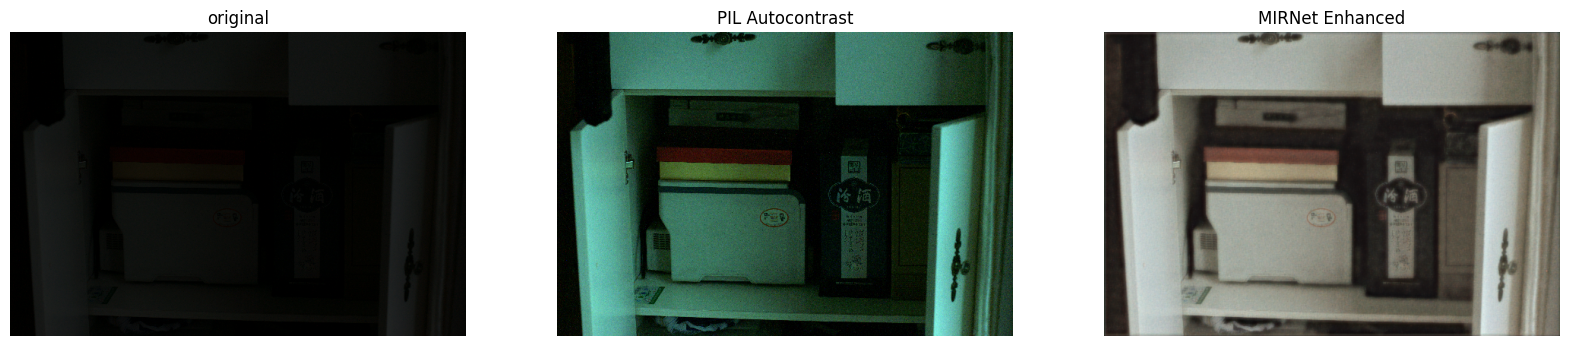

1/1 [==============================] - 1s 569ms/step


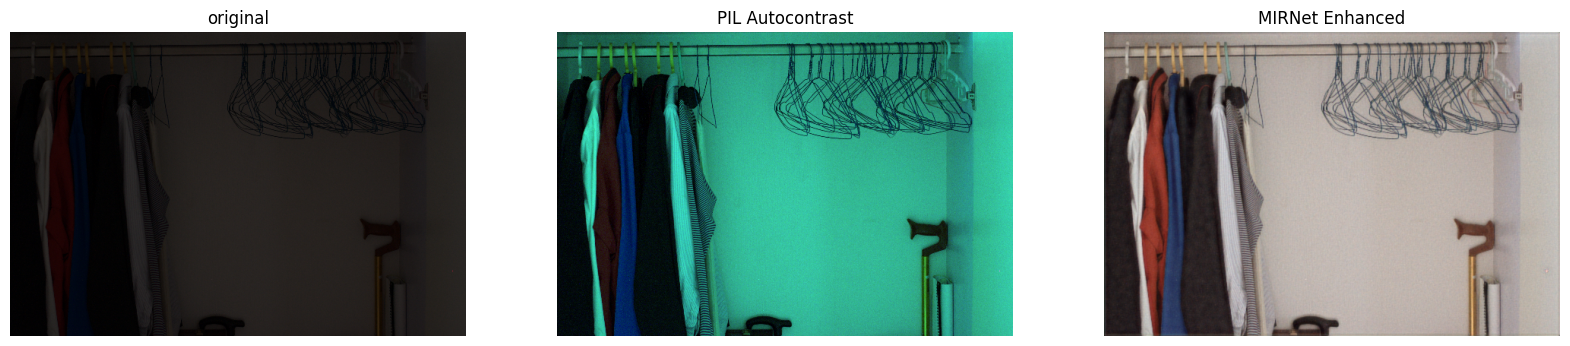

1/1 [==============================] - 1s 574ms/step


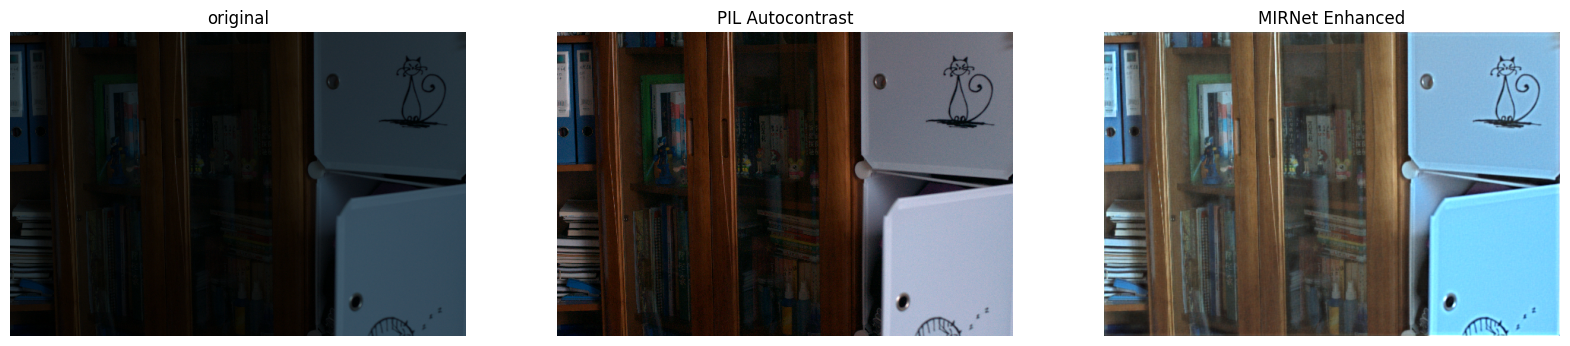

1/1 [==============================] - 1s 576ms/step


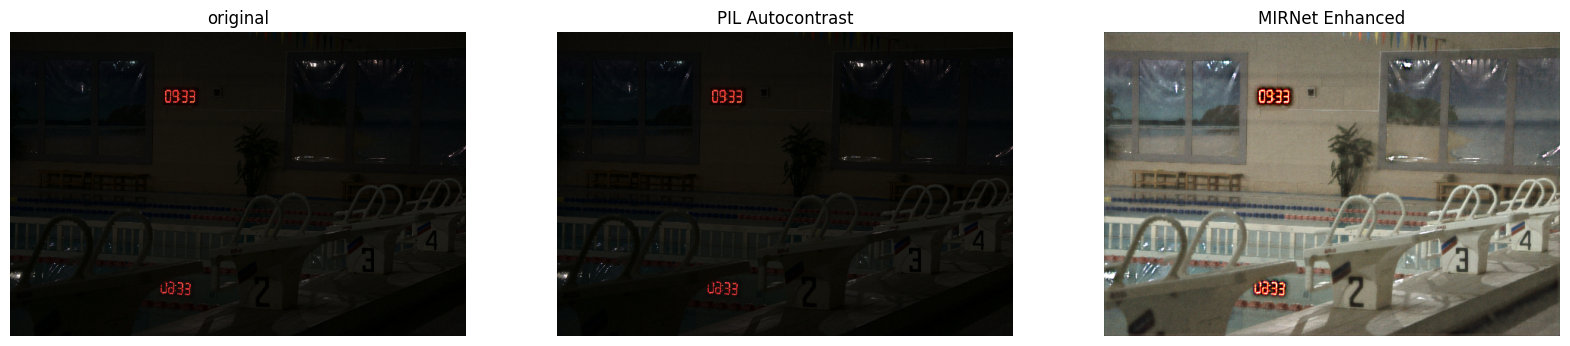

1/1 [==============================] - 1s 578ms/step


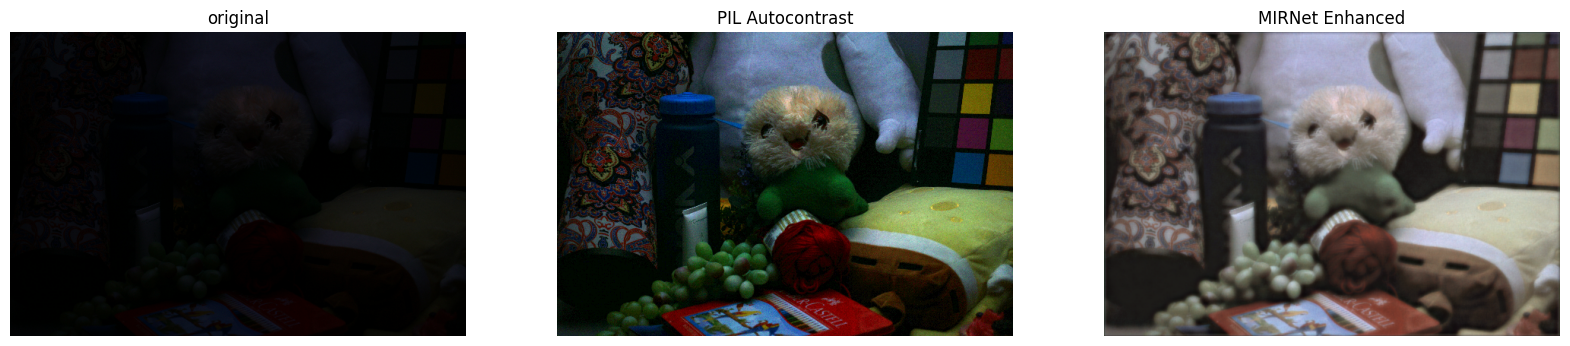

1/1 [==============================] - 1s 572ms/step


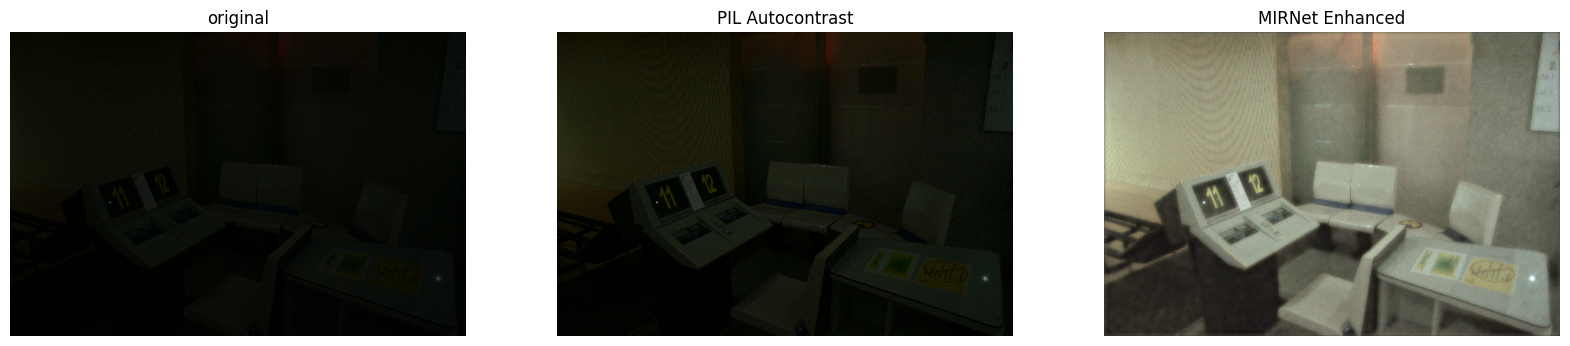

In [19]:
for low_light_image in random.sample(test_low_light_images, 6):
  original_image = Image.open(low_light_image)
  enhanced_image = infer(original_image)
  plot_results(
      [original_image, ImageOps.autocontrast(original_image), enhanced_image],
      ["original", "PIL Autocontrast", "MIRNet Enhanced"],
      (20, 12),
  )